# 敏感性分析代码

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
# 读取CSV文件
def load_data(filepath):
    """
    读取包含全年小时数据的CSV文件
    返回: DataFrame(日期时间, 各特征列)
    """
    # 假设CSV文件包含日期时间和各特征列
    df = pd.read_csv(filepath)
    
    # 确保有日期时间列(如果没有则创建)
    if 'datetime' not in df.columns:
        # 假设数据是按小时顺序排列的全年数据
        start_date = datetime(2023, 1, 1)  # 根据实际情况调整
        df['datetime'] = [start_date + timedelta(hours=i) for i in range(len(df))]
    
    # 将datetime列转换为datetime对象(如果尚未转换)
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    return df

# 使用示例
filepath = 'feature.csv'  # 替换为实际文件路径
data = load_data(filepath)
print(data.head())

   order   pv        wt    load            datetime
0      0  0.0  0.874944  4.3344 2023-01-01 00:00:00
1      1  0.0  0.876171  6.5016 2023-01-01 01:00:00
2      2  0.0  0.761241  7.5852 2023-01-01 02:00:00
3      3  0.0  0.582960  8.6688 2023-01-01 03:00:00
4      4  0.0  0.824549  8.6688 2023-01-01 04:00:00


In [3]:
def preprocess_daily_data(df, feature_columns):
    """
    将小时数据按天重组为三维数组(天, 小时, 特征)
    参数:
        df: 原始DataFrame
        feature_columns: 要使用的特征列名列表(如['wind', 'solar', 'load'])
    返回:
        X: 三维数组(天, 24小时, 特征)
        dates: 对应的日期列表
    """
    # 提取日期部分(去掉具体时间)
    df['date'] = df['datetime'].dt.date
    
    # 按天分组
    daily_groups = df.groupby('date')
    
    # 初始化三维数组
    n_days = len(daily_groups)
    n_hours = 24
    n_features = len(feature_columns)
    X = np.zeros((n_days, n_hours, n_features))
    dates = []
    
    # 填充数组
    for i, (date, group) in enumerate(daily_groups):
        # 确保每天有24小时数据(如有缺失需要处理)
        if len(group) == 24:
            X[i] = group[feature_columns].values
            dates.append(date)
        else:
            print(f"警告: 日期 {date} 数据不完整(只有 {len(group)} 小时数据)")
    
    # 标准化数据(对每个特征分别标准化)
    
    return X

# 选择要使用的特征列
feature_cols = ['pv','wt','load']  # 根据实际列名调整

# 预处理数据
X = preprocess_daily_data(data, feature_cols)
print(f"数据形状: {X.shape} (天数, 小时, 特征)")

数据形状: (364, 24, 3) (天数, 小时, 特征)


In [5]:
labels=np.load("labels.npy")
print(len(labels))

364


In [ ]:
import random
a=[]
for i in range(9):
    a.append([])

[[], [], [], [], [], [], [], [], []]
[[1], [], [], [], [], [], [], [], []]


In [12]:
for i in range(364):
    a[labels[i]].append(i)

In [20]:
w=X[a[0][random.randint(0,len(a[0])-1)],:,:]
for i in range(1,9):
    w=np.vstack([w,X[a[i][random.randint(0,len(a[i])-1)],:,:]])

In [ ]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf
def sens_analysis(p,w):

    # Constants and parameters
    M = 1e6
    T = list(range(24*9))  # Time periods



    factor_wt = w[:,1]
    factor_pv = w[:,0]
    factor_load = w[:,2]

    # Create Pyomo model
    model = pyo.ConcreteModel()

    # Time index set
    model.T = pyo.Set(initialize=T)

    # Electricity price generation (equivalent to your Julia function)
    def generate_electricity_price():
        price = [3,3,3,3,2,2,2,2,4,4,4,3,3,2,1,1,2,3,3,4,4,5,5,4]*9
        price_mapping = {1:0.1049, 2:0.1411, 3:0.3223, 4:0.5035, 5:0.5639}
        return [price_mapping.get(p,p) for p in price]

    price = np.array(generate_electricity_price())

    # Load calculations
    H_Load = 175 * 3.25 * factor_load
    Q_Load = (4.2*751.13 + 2.9*740.2 + 1*735.7) * factor_load
    L_Load = (31700 + 600) * factor_load

    # Variables
    model.priceH = pyo.Var(model.T,within=pyo.NonNegativeReals,bounds=(0,1))
    model.lambd = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu1 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_buy = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_ET2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_ET2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu3 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.lambd2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu4 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu5 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.Q_buy = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.Q_HP = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_HP = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.mu6 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.priceQ = pyo.Var(model.T, within=pyo.NonNegativeReals, bounds=(0,1))

    # Investment costs
    IC_ET2 = 5e4
    IC_HP = 2e4
    IC_ET = 13191
    IC_FC = 3233
    IC_ES = 23996
    IC_HS = 10864
    IC_WT = 55887
    IC_PV = 21272

    # Electrolyzer (ET) constraints
    model.E_ET = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_ET = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_ET_SELL = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def et_efficiency_rule(model, t):
        return model.H_ET[t] == model.E_ET[t] * 0.63#0.63
    model.et_efficiency = pyo.Constraint(model.T, rule=et_efficiency_rule)

    def et_capacity_rule(model, t):
        return model.E_ET[t] <= IC_ET
    model.et_capacity = pyo.Constraint(model.T, rule=et_capacity_rule)

    def et_sell_rule(model, t):
        return model.H_ET_SELL[t] == model.H_buy[t]
    model.et_sell = pyo.Constraint(model.T, rule=et_sell_rule)

    # Fuel Cell (FC) constraints
    model.H_FC = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_FC = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.Q_FC = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_FC2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_FC2 = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.Q_FC2 = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def fc_efficiency_rule(model, t):
        return model.E_FC[t] == model.H_FC[t] * 0.57
    model.fc_efficiency = pyo.Constraint(model.T, rule=fc_efficiency_rule)

    def fc_heat_rule(model, t):
        return model.Q_FC[t] == model.H_FC[t] * 0.28
    model.fc_heat = pyo.Constraint(model.T, rule=fc_heat_rule)

    def fc2_efficiency_rule(model, t):
        return model.E_FC2[t] == model.H_FC2[t] * 0.57#0.57
    model.fc2_efficiency = pyo.Constraint(model.T, rule=fc2_efficiency_rule)

    def fc2_heat_rule(model, t):
        return model.Q_FC2[t] == model.H_FC2[t] * 0.28
    model.fc2_heat = pyo.Constraint(model.T, rule=fc2_heat_rule)

    def fc2_qbuy_rule(model, t):
        return model.Q_FC2[t] <= model.Q_buy[t]
    model.fc2_qbuy = pyo.Constraint(model.T, rule=fc2_qbuy_rule)

    def fc_capacity_rule(model, t):
        return model.E_FC2[t] + model.E_FC[t] <= IC_FC*0.57
    model.fc_capacity = pyo.Constraint(model.T, rule=fc_capacity_rule)

    # Electricity Storage (ES) constraints
    model.E_ES = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_ES_in = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_ES_out = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.gamma = pyo.Var(model.T, within=pyo.Binary)

    ηI_ES = 0.96
    ηO_ES = 0.96
    r_ES = 0.5
    min_ES = 0.1
    max_ES = 1.0
    ini_ES = 0.2
    loss_ES = 0.01

    def es_initial_rule(model):
        return model.E_ES[0] == ini_ES * IC_ES * (1 - loss_ES) + model.E_ES_in[0] * ηI_ES - model.E_ES_out[0] / ηO_ES
    model.es_initial = pyo.Constraint(rule=es_initial_rule)

    def es_balance_rule(model, t):
        if t > 0:
            return model.E_ES[t] == model.E_ES[t-1] * (1 - loss_ES) + model.E_ES_in[t] * ηI_ES - model.E_ES_out[t] / ηO_ES
        return pyo.Constraint.Skip
    model.es_balance = pyo.Constraint(model.T, rule=es_balance_rule)

    def es_in_limit_rule(model, t):
        return model.E_ES_in[t] <= r_ES * IC_ES
    model.es_in_limit = pyo.Constraint(model.T, rule=es_in_limit_rule)

    def es_out_limit_rule(model, t):
        return model.E_ES_out[t] <= r_ES * IC_ES
    model.es_out_limit = pyo.Constraint(model.T, rule=es_out_limit_rule)

    def es_min_rule(model, t):
        return min_ES * IC_ES <= model.E_ES[t]
    model.es_min = pyo.Constraint(model.T, rule=es_min_rule)

    def es_max_rule(model, t):
        return model.E_ES[t] <= max_ES * IC_ES
    model.es_max = pyo.Constraint(model.T, rule=es_max_rule)

    def es_final_rule(model):
        return model.E_ES[max(T)] == ini_ES * IC_ES
    model.es_final = pyo.Constraint(rule=es_final_rule)

    def es_in_bin_rule(model, t):
        return model.E_ES_in[t] <= model.gamma[t]*M
    model.es_in_bin = pyo.Constraint(model.T, rule=es_in_bin_rule)

    def es_out_bin_rule(model, t):
        return model.E_ES_out[t] <= (1-model.gamma[t])*M
    model.es_out_bin = pyo.Constraint(model.T, rule=es_out_bin_rule)

    # Hydrogen Storage (HS) constraints
    model.H_HS = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_HS_in = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_HS_out = pyo.Var(model.T, within=pyo.NonNegativeReals)

    ηI_HS = 0.8
    ηO_HS = 0.8
    r_HS = 0.25
    min_HS = 0.1
    max_HS = 1.0
    ini_HS = 0.15
    loss_HS = 0.001

    def hs_initial_rule(model):
        return model.H_HS[0] == ini_HS * IC_HS * (1 - loss_HS) + model.H_HS_in[0] * ηI_HS - model.H_HS_out[0] / ηO_HS
    model.hs_initial = pyo.Constraint(rule=hs_initial_rule)

    def hs_balance_rule(model, t):
        if t > 0:
            return model.H_HS[t] == model.H_HS[t-1] * (1 - loss_HS) + model.H_HS_in[t] * ηI_HS - model.H_HS_out[t] / ηO_HS
        return pyo.Constraint.Skip
    model.hs_balance = pyo.Constraint(model.T, rule=hs_balance_rule)

    def hs_in_limit_rule(model, t):
        return model.H_HS_in[t] <= r_HS * IC_HS
    model.hs_in_limit = pyo.Constraint(model.T, rule=hs_in_limit_rule)

    def hs_out_limit_rule(model, t):
        return model.H_HS_out[t] <= r_HS * IC_HS
    model.hs_out_limit = pyo.Constraint(model.T, rule=hs_out_limit_rule)

    def hs_min_rule(model, t):
        return min_HS * IC_HS <= model.H_HS[t]
    model.hs_min = pyo.Constraint(model.T, rule=hs_min_rule)

    def hs_max_rule(model, t):
        return model.H_HS[t] <= max_HS * IC_HS
    model.hs_max = pyo.Constraint(model.T, rule=hs_max_rule)

    def hs_final_rule(model):
        return model.H_HS[max(T)] == ini_HS * IC_HS
    model.hs_final = pyo.Constraint(rule=hs_final_rule)

    # Wind Turbine (WT) constraints
    P_WT = IC_WT * factor_wt
    model.E_WT = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_WT_dis = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def wt_capacity_rule(model, t):
        return model.E_WT[t] <= P_WT[t]
    model.wt_capacity = pyo.Constraint(model.T, rule=wt_capacity_rule)

    def wt_balance_rule(model, t):
        return model.E_WT[t] + model.E_WT_dis[t] == P_WT[t]
    model.wt_balance = pyo.Constraint(model.T, rule=wt_balance_rule)

    # PV constraints
    P_PV = IC_PV * factor_pv
    model.E_PV = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_PV_dis = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def pv_capacity_rule(model, t):
        return model.E_PV[t] <= P_PV[t]
    model.pv_capacity = pyo.Constraint(model.T, rule=pv_capacity_rule)

    def pv_balance_rule(model, t):
        return model.E_PV[t] + model.E_PV_dis[t] == P_PV[t]
    model.pv_balance = pyo.Constraint(model.T, rule=pv_balance_rule)

    # Market interactions
    model.E_BUY = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_SELL = pyo.Var(model.T, within=pyo.NonNegativeReals)

    def sell_limit_rule(model, t):
        return model.E_SELL[t] <= (L_Load[t] + model.E_ET2[t] + model.E_HP[t]) * 0.2
    def sell_limit_rule2(model, t):
        return model.E_SELL[t] <= (L_Load[t]) * 0.2
    def sell_limit_rule3(model, t):
        return model.E_SELL[t]-model.E_FC[t] <= (L_Load[t] + model.E_ET2[t] + model.E_HP[t]) * 0.2
    model.sell_limit = pyo.Constraint(model.T, rule=sell_limit_rule)

    # Power balance constraints
    def power_balance_rule(model, t):
        return (model.E_WT[t] + model.E_PV[t] + model.E_BUY[t] + model.E_FC[t] + 
                model.E_FC2[t] + model.E_ES_out[t] == 
                model.E_ET[t] + model.E_ES_in[t] + model.E_SELL[t])
    def power_balance_rule2(model, t):
        return (model.E_WT[t] + model.E_PV[t] + model.E_BUY[t]  + model.E_ES_out[t] == 
                model.E_ET[t] + model.E_ES_in[t] + model.E_SELL[t])
    def power_balance_rule3(model, t):
        return (model.E_WT[t] + model.E_PV[t] + model.E_BUY[t] + model.E_FC[t] + 
                model.E_FC2[t] + model.E_ES_out[t] >= 
                model.E_ET[t] + model.E_ES_in[t] + model.E_SELL[t])
    model.power_balance = pyo.Constraint(model.T, rule=power_balance_rule)

    def hydrogen_balance_rule(model, t):
        return model.H_ET[t] + model.H_HS_out[t] == (model.H_FC[t] + model.H_FC2[t] + 
                                                model.H_HS_in[t] + model.H_ET_SELL[t])
    model.hydrogen_balance = pyo.Constraint(model.T, rule=hydrogen_balance_rule)

    # KKT conditions for ET2
    model.gamma1 = pyo.Var(model.T, within=pyo.Binary)
    model.gamma2 = pyo.Var(model.T, within=pyo.Binary)
    model.gamma3 = pyo.Var(model.T, within=pyo.Binary)

    def kkt1_rule(model, t):
        return price[t] + p - model.lambd[t]*0.71 - model.mu1[t] + model.mu3[t] == 0
    model.kkt1 = pyo.Constraint(model.T, rule=kkt1_rule)

    def kkt2_rule(model, t):
        return model.priceH[t] - model.lambd[t] - model.mu2[t] == 0
    model.kkt2 = pyo.Constraint(model.T, rule=kkt2_rule)

    def mu1_bin_rule(model, t):
        return model.mu1[t] <= (1-model.gamma1[t])*M
    model.mu1_bin = pyo.Constraint(model.T, rule=mu1_bin_rule)

    def et2_bin_rule(model, t):
        return model.E_ET2[t] <= model.gamma1[t]*M
    model.et2_bin = pyo.Constraint(model.T, rule=et2_bin_rule)

    def mu2_bin_rule(model, t):
        return model.mu2[t] <= (1-model.gamma2[t])*M
    model.mu2_bin = pyo.Constraint(model.T, rule=mu2_bin_rule)

    def hbuy_bin_rule(model, t):
        return model.H_buy[t] <= model.gamma2[t]*M
    model.hbuy_bin = pyo.Constraint(model.T, rule=hbuy_bin_rule)

    def et2_h_rule(model, t):
        return model.H_ET2[t] == 0.71 * model.E_ET2[t]
    model.et2_h = pyo.Constraint(model.T, rule=et2_h_rule)

    def h_load_rule(model, t):
        return model.H_buy[t] + model.H_ET2[t] == H_Load[t]
    model.h_load = pyo.Constraint(model.T, rule=h_load_rule)

    def mu3_bin_rule(model, t):
        return model.mu3[t] <= (1-model.gamma3[t])*M
    model.mu3_bin = pyo.Constraint(model.T, rule=mu3_bin_rule)

    def et2_cap_bin_rule(model, t):
        return IC_ET2 - model.E_ET2[t] <= model.gamma3[t]*M
    model.et2_cap_bin = pyo.Constraint(model.T, rule=et2_cap_bin_rule)

    # KKT conditions for HP
    model.gamma4 = pyo.Var(model.T, within=pyo.Binary)
    model.gamma5 = pyo.Var(model.T, within=pyo.Binary)
    model.gamma6 = pyo.Var(model.T, within=pyo.Binary)

    def kkt3_rule(model, t):
        return price[t] + p - model.lambd2[t]*4 - model.mu4[t] + model.mu6[t] == 0
    model.kkt3 = pyo.Constraint(model.T, rule=kkt3_rule)

    def kkt4_rule(model, t):
        return model.priceQ[t] - model.lambd2[t] - model.mu5[t] == 0
    model.kkt4 = pyo.Constraint(model.T, rule=kkt4_rule)

    def mu4_bin_rule(model, t):
        return model.mu4[t] <= (1-model.gamma4[t])*M
    model.mu4_bin = pyo.Constraint(model.T, rule=mu4_bin_rule)

    def hp_bin_rule(model, t):
        return model.E_HP[t] <= model.gamma4[t]*M
    model.hp_bin = pyo.Constraint(model.T, rule=hp_bin_rule)

    def mu5_bin_rule(model, t):
        return model.mu5[t] <= (1-model.gamma5[t])*M
    model.mu5_bin = pyo.Constraint(model.T, rule=mu5_bin_rule)

    def qbuy_bin_rule(model, t):
        return model.Q_buy[t] <= model.gamma5[t]*M
    model.qbuy_bin = pyo.Constraint(model.T, rule=qbuy_bin_rule)

    def hp_q_rule(model, t):
        return model.Q_HP[t] == 4 * model.E_HP[t]
    model.hp_q = pyo.Constraint(model.T, rule=hp_q_rule)

    def q_load_rule(model, t):
        return model.Q_buy[t] + model.Q_HP[t] == Q_Load[t]
    model.q_load = pyo.Constraint(model.T, rule=q_load_rule)

    def mu6_bin_rule(model, t):
        return model.mu6[t] <= (1-model.gamma6[t])*M
    model.mu6_bin = pyo.Constraint(model.T, rule=mu6_bin_rule)

    def hp_cap_bin_rule(model, t):
        return IC_HP - model.E_HP[t] <= model.gamma6[t]*M
    model.hp_cap_bin = pyo.Constraint(model.T, rule=hp_cap_bin_rule)

    # Objective function
    def objective_rule(model):
        return (sum(model.E_SELL[t] * price[t]*0.95 for t in model.T) + 
                sum(model.H_ET_SELL[t] * model.priceH[t] for t in model.T) - 
                sum(price[t] * model.E_BUY[t] for t in model.T))
    def objective_rule2(model):
        return (sum(model.E_SELL[t] * price[t]*0.95 for t in model.T) + 
                sum(model.H_ET_SELL[t] * model.priceH[t] for t in model.T) - 
                sum((price[t]+p) * model.E_BUY[t] for t in model.T)+sum(model.Q_FC2[t]*model.priceQ[t] for t in model.T))
    def objective_rule3(model):
        return (sum(model.E_SELL[t] * price[t]*0.95 for t in model.T) + 
                sum(model.H_ET_SELL[t] * model.priceH[t] for t in model.T) - 
                sum((price[t]+p) * model.E_BUY[t] for t in model.T)+sum(model.Q_FC2[t]*model.priceQ[t] for t in model.T)+sum(model.E_FC2[t]*price[t]*0.95 for t in model.T))
    def objective_rule4(model):
        return (sum(model.E_SELL[t] * (price[t]-0.05) for t in model.T) + 
                sum(model.H_ET_SELL[t] * model.priceH[t] for t in model.T) - 
                sum((price[t]+p) * model.E_BUY[t] for t in model.T)+sum(model.Q_FC2[t]*model.priceQ[t] for t in model.T))
    model.objective = pyo.Objective(rule=objective_rule2, sense=pyo.maximize)

    # Solve the model
    solver = pyo.SolverFactory('gurobi')  # or 'ipopt' for nonlinear problems
    solver.options['TimeLimit'] = 50
    solver.options['MIPGap'] = 0.01
    results = solver.solve(model, tee=False)

    # Print results
    print("Solver status:", results.solver.status)
    print("Termination condition:", results.solver.termination_condition)

    # Post-processing (similar to your Julia code)
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        et = [-pyo.value(model.E_ET[t])/IC_ET for t in model.T]
        fc = [-pyo.value(model.E_FC2[t])/IC_FC for t in model.T]
        es = [pyo.value(model.E_ES[t])/IC_ES for t in model.T]
        hs = [pyo.value(model.H_HS[t])/IC_HS for t in model.T]
        sell = [pyo.value(model.E_SELL[t])/1e5 for t in model.T]
        buy = [pyo.value(model.E_BUY[t])/1e6 for t in model.T]
        Hbuy=[pyo.value(model.H_buy[t]) for t in model.T]
        re = [(pyo.value(model.E_WT[t]) + pyo.value(model.E_PV[t]))/(IC_PV+IC_WT) for t in model.T]
        H2 = [pyo.value(model.H_ET_SELL[t])/H_Load[t] for t in model.T]
        dis = [(pyo.value(model.E_PV_dis[t]) + pyo.value(model.E_WT_dis[t])) for t in model.T]
        output=P_PV+P_WT
        priceQ=[pyo.value(model.priceQ[t])for t in model.T]
        priceH=[pyo.value(model.priceH[t])for t in model.T]
        priceH=np.array(priceH)*3.25/0.089
        priceH2=np.array(price)/0.63*3.25/0.089
        rewardE=[(pyo.value(model.E_SELL[t] * price[t]*0.95))for t in model.T]
        rewardH=[(pyo.value(model.H_ET_SELL[t] * model.priceH[t])) for t in model.T]
        rewardQ=[(pyo.value(model.Q_FC2[t]*model.priceQ[t])) for t in model.T]
        reward2=[sum(rewardE),sum(rewardH),sum(rewardQ)]
        dis_real=sum(dis)/sum(output)
        green_H2=sum(H2*H_Load)/sum(H_Load)
        reward=pyo.value(model.objective)/9
        buy_ratio=sum(buy)*1e6/(sum(buy)*1e6+sum(output))
        cashflow=[]
        inv1=IC_ET * 6000 +  IC_FC * 8000 + IC_ES * 2000 + IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500
        cashflow.append(-inv1)
        cOM=IC_ET * 6000*0.035+IC_FC * 8000*0.035+IC_ES * 2000*0.025+IC_HS * 4000*0.015+(IC_WT * 4300 + IC_PV * 3500)*0.01
        cOM2=IC_ET*26+IC_FC*26+IC_ES*26+IC_HS*26+IC_PV*26+IC_PV*14
        depreciation=(IC_ET * 6000*2 +  IC_FC * 8000 + IC_ES * 2000*2 + IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)/20
        inv2=0
        for i in range(0,10):
            inv=(IC_ET * 6000 +IC_ES * 2000)*(10-i)/10 +  (IC_FC * 8000 +  IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)*(19-i)/20
            inv2+=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)/(1.06**(i+1))
            temp=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)
            cashflow.append(temp)
        inv=(IC_ET * 6000 +IC_ES * 2000)*(19-10)/10 +  (IC_FC * 8000 +  IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)*(19-10)/20
        temp=(reward*365-(IC_ET * 6000 +IC_ES * 2000)-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)
        cashflow.append(temp)
        inv2+=(reward*365-(IC_ET * 6000 +IC_ES * 2000)-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)/(1.06**(10+1))
        for i in range(11,20):
            inv=(IC_ET * 6000 +IC_ES * 2000)*(19-i)/10 +  (IC_FC * 8000 +  IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)*(19-i)/20
            inv2+=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)/(1.06**(i+1))
            temp=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)
            cashflow.append(temp)
        irr=npf.irr(cashflow)
        return [green_H2,reward,inv2-inv1,irr]

In [27]:
def generate_w(X):
    w=X[a[0][random.randint(0,len(a[0])-1)],:,:]
    for i in range(1,9):
       w=np.vstack([w,X[a[i][random.randint(0,len(a[i])-1)],:,:]])
    return w

In [ ]:
result=np.zeros((1000,4))
for i in range(1000):
     result[i,:]=sens_analysis(0,generate_w(X))
     print(f"{i}/1000")

(array([153., 196.,  57., 105., 355., 122.,   4.,   0.,   0.,   8.]),
 array([0.0910002 , 0.12701399, 0.16302778, 0.19904158, 0.23505537,
        0.27106916, 0.30708296, 0.34309675, 0.37911054, 0.41512434,
        0.45113813]),
 <BarContainer object of 10 artists>)

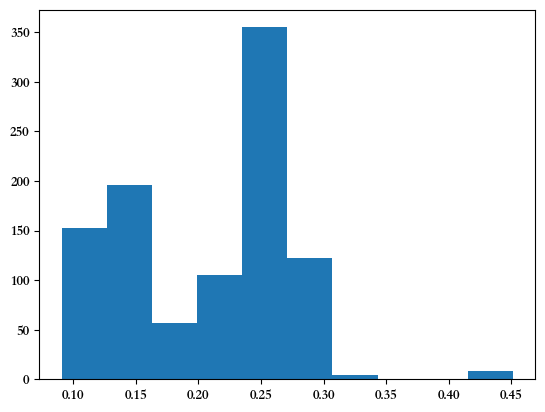

In [3]:
import numpy as np
import matplotlib.pyplot as plt
result=np.load("sense.npy")
f=plt.figure()
plt.hist(result[:,0])

In [45]:
np.save("sense.npy",result)

<Figure size 1920x1440 with 0 Axes>

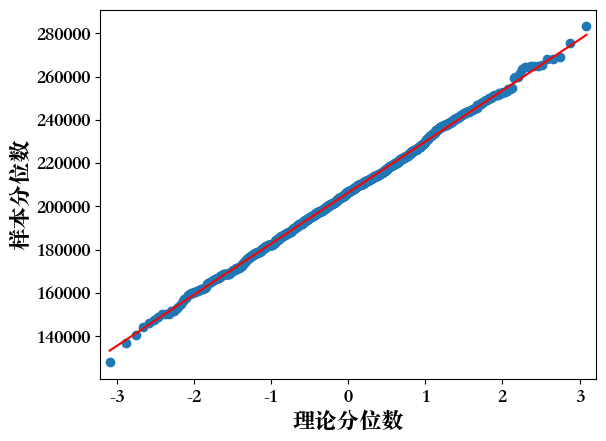

In [4]:
import statsmodels.api as sm
import numpy as np

# 生成模拟数据
data = result[:,1]

# 使用statsmodels拟合
ecdf = sm.distributions.ECDF(data)
plt.figure(dpi=300)
sm.qqplot(data, line='s')
plt.xlabel("理论分位数",fontsize=16)
plt.ylabel("样本分位数",fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

拟合的均值: 206305.8299
拟合的标准差: 23601.1277


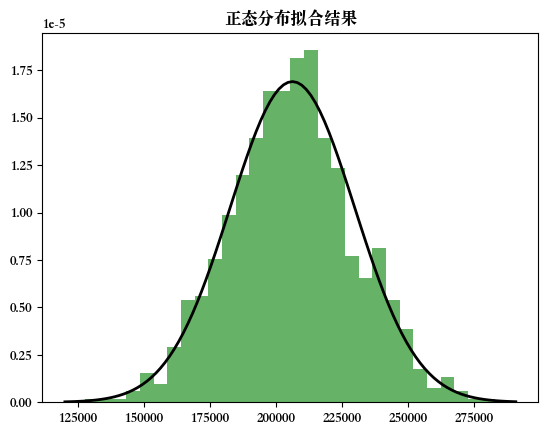

In [48]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 生成模拟数据
data = result[:,1]

# 拟合正态分布
mu, std = norm.fit(data)

# 打印拟合参数
print(f"拟合的均值: {mu:.4f}")
print(f"拟合的标准差: {std:.4f}")

# 绘制直方图和拟合曲线
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# 绘制拟合的PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("正态分布拟合结果")
plt.show()

In [1]:
def comprehensive_normality_test(data, alpha=0.05):
    """综合正态性检验函数"""
    from scipy.stats import shapiro, kstest, normaltest, anderson
    
    print("=== 正态性检验综合报告 ===")
    print(f"样本量: {len(data)}")
    
    # Shapiro-Wilk (适合小样本)
    if len(data) <= 50:
        stat, p = shapiro(data)
        print(f"\n1. Shapiro-Wilk 检验:")
        print(f"  统计量: {stat:.4f}, P值: {p:.4f}")
        print(f"  结论: {'不能拒绝正态性' if p > alpha else '拒绝正态性'}")
    
    # Kolmogorov-Smirnov
    mu, std = data.mean(), data.std()
    stat, p = kstest(data, 'norm', args=(mu, std))
    print(f"\n2. Kolmogorov-Smirnov 检验:")
    print(f"  统计量: {stat:.4f}, P值: {p:.4f}")
    print(f"  结论: {'不能拒绝正态性' if p > alpha else '拒绝正态性'}")
    
    # D'Agostino's K²
    stat, p = normaltest(data)
    print(f"\n3. D'Agostino's K² 检验:")
    print(f"  统计量: {stat:.4f}, P值: {p:.4f}")
    print(f"  结论: {'不能拒绝正态性' if p > alpha else '拒绝正态性'}")
    
    # Anderson-Darling
    print("\n4. Anderson-Darling 检验:")
    result = anderson(data)
    print(f"  统计量: {result.statistic:.4f}")
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print(f"  在 {sl}% 水平下: 不能拒绝正态性")
        else:
            print(f"  在 {sl}% 水平下: 拒绝正态性")

# 使用示例
import numpy as np
d=np.load("sense.npy")
data = np.random.normal(size=100)
comprehensive_normality_test(d[:,1])

=== 正态性检验综合报告 ===
样本量: 1000

2. Kolmogorov-Smirnov 检验:
  统计量: 0.0196, P值: 0.8303
  结论: 不能拒绝正态性

3. D'Agostino's K² 检验:
  统计量: 0.2342, P值: 0.8895
  结论: 不能拒绝正态性

4. Anderson-Darling 检验:
  统计量: 0.3245
  在 15.0% 水平下: 不能拒绝正态性
  在 10.0% 水平下: 不能拒绝正态性
  在 5.0% 水平下: 不能拒绝正态性
  在 2.5% 水平下: 不能拒绝正态性
  在 1.0% 水平下: 不能拒绝正态性


In [7]:
def generate_npv(mu,sigma):
        import numpy_financial as npf
        IC_ET2 = 5e4
        IC_HP = 2e4
        IC_ET = 13191
        IC_FC = 3233
        IC_ES = 23996
        IC_HS = 10864
        IC_WT = 55887
        IC_PV = 21272     
        cashflow=[]
        inv1=IC_ET * 6000 +  IC_FC * 8000 + IC_ES * 2000 + IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500
        cashflow.append(-inv1)
        cOM=IC_ET * 6000*0.035+IC_FC * 8000*0.035+IC_ES * 2000*0.025+IC_HS * 4000*0.015+(IC_WT * 4300 + IC_PV * 3500)*0.01
        cOM2=IC_ET*26+IC_FC*26+IC_ES*26+IC_HS*26+IC_PV*26+IC_PV*14
        depreciation=(IC_ET * 6000*2 +  IC_FC * 8000 + IC_ES * 2000*2 + IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)/20
        inv2=0
        for i in range(0,10):
            reward=np.random.normal(mu,sigma,1)[0]
            inv=(IC_ET * 6000 +IC_ES * 2000)*(10-i)/10 +  (IC_FC * 8000 +  IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)*(19-i)/20
            inv2+=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)/(1.06**(i+1))
            temp=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)
            cashflow.append(temp)
        inv=(IC_ET * 6000 +IC_ES * 2000)*(19-10)/10 +  (IC_FC * 8000 +  IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)*(19-10)/20
        reward=np.random.normal(mu,sigma,1)[0]
        temp=(reward*365-(IC_ET * 6000 +IC_ES * 2000)-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)
        cashflow.append(temp)
        inv2+=(reward*365-(IC_ET * 6000 +IC_ES * 2000)-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)/(1.06**(10+1))
        for i in range(11,20):
            reward=np.random.normal(mu,sigma,1)[0]
            inv=(IC_ET * 6000 +IC_ES * 2000)*(19-i)/10 +  (IC_FC * 8000 +  IC_HS * 4000 + IC_WT * 4300 + IC_PV * 3500)*(19-i)/20
            inv2+=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)/(1.06**(i+1))
            temp=(reward*365-cOM2-inv*0.25/100-(reward*365-depreciation)*0.25)
            cashflow.append(temp)
        irr=npf.irr(cashflow)
        return [inv2-inv1,irr]

In [8]:
result2=np.zeros((1000,2))
for i in range(1000):
    result2[i,:]= generate_npv(206305.8299,23601.1277)

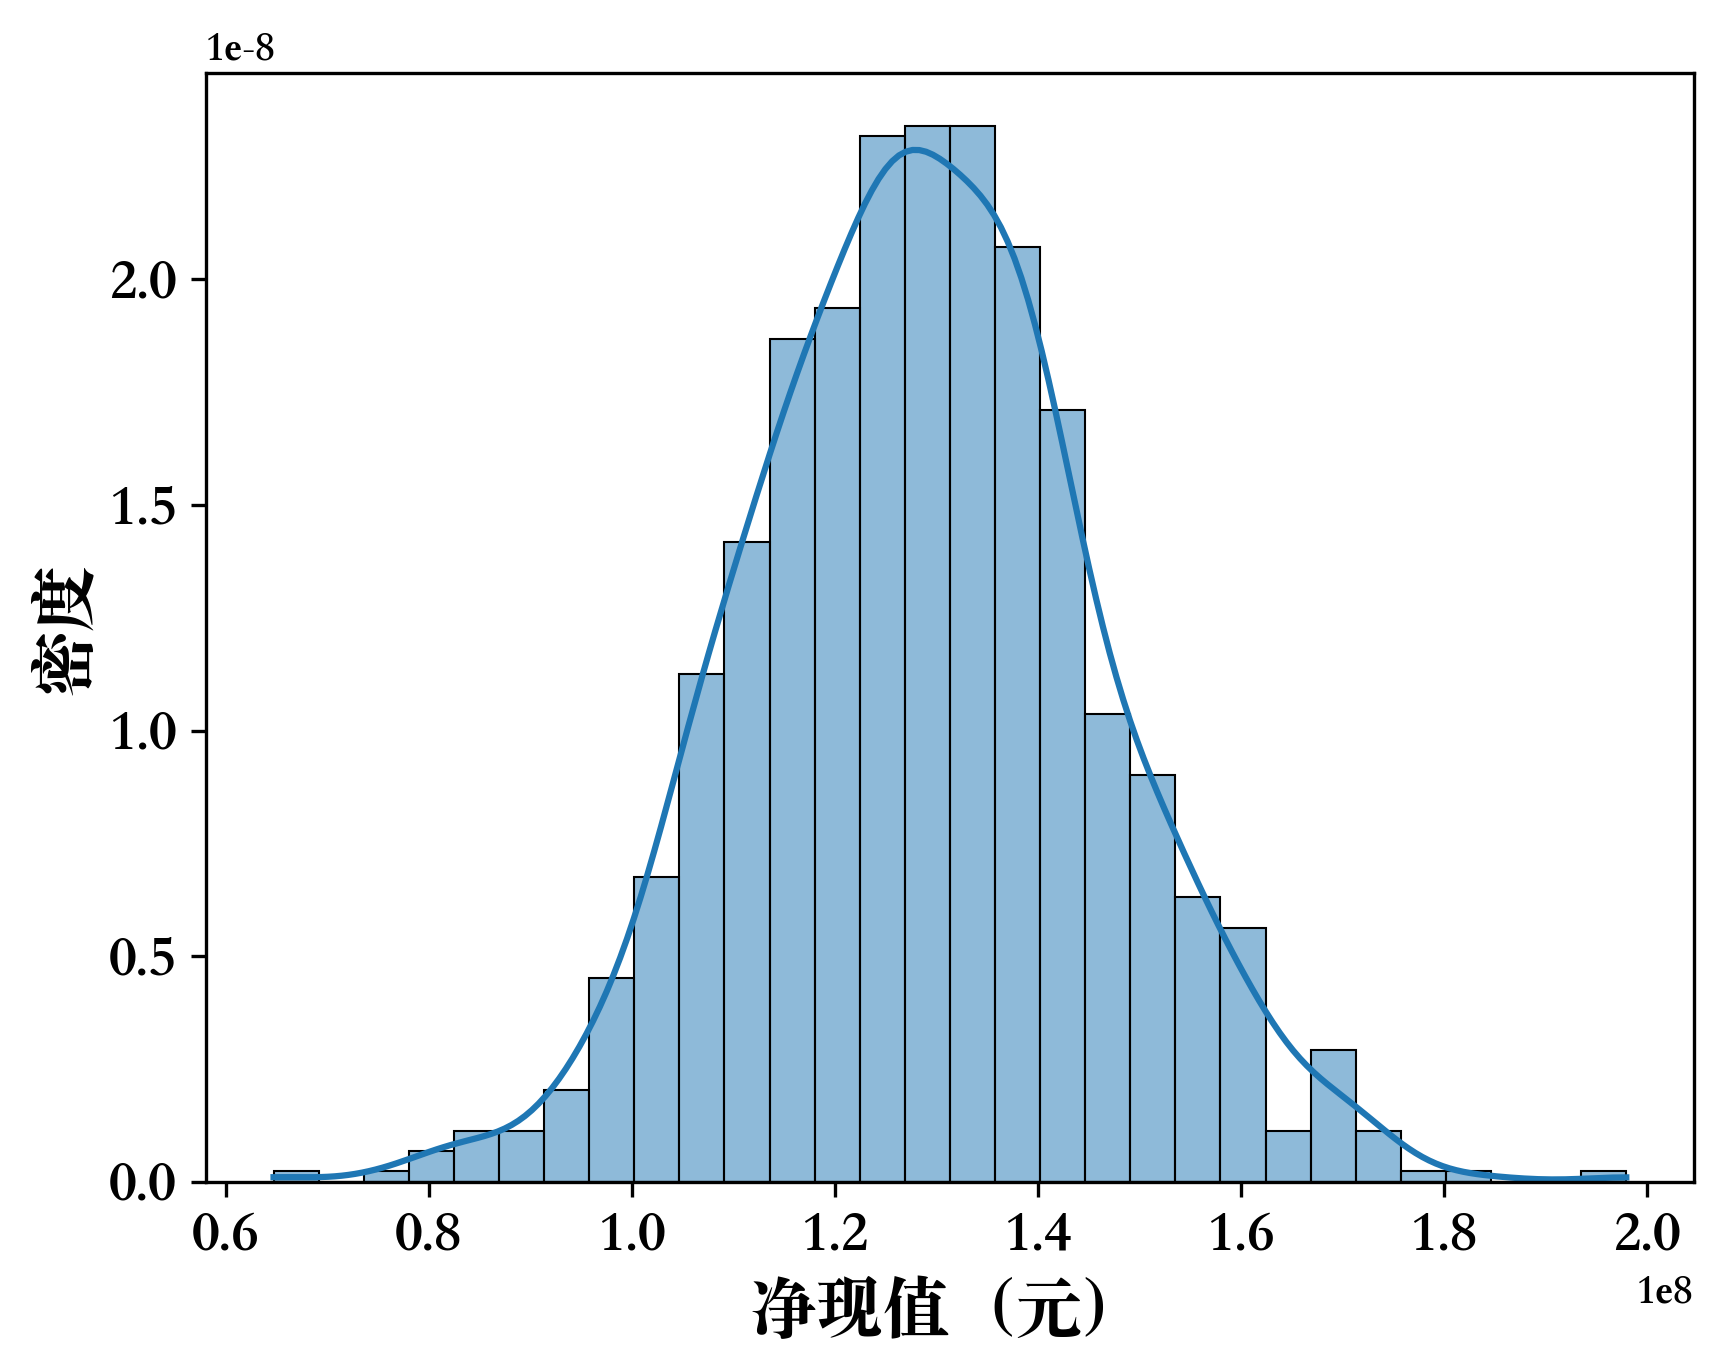

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据
data = result2[:,0]
plt.rcParams['font.sans-serif'] = ['Songti SC']  # Linux 常用
plt.rcParams['axes.unicode_minus'] = False 
# 绘制带KDE的直方图
plt.figure(dpi=300)
sns.histplot(data, bins=30, kde=True, stat='density', 
            edgecolor='black', linewidth=0.5)

#plt.title('直方图+密度曲线（Seaborn）')
#plt.xlabel('绿氢渗透率')
plt.xlabel('净现值（元）',fontsize=16)
plt.ylabel('密度',fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

Text(0, 0.5, '频数')

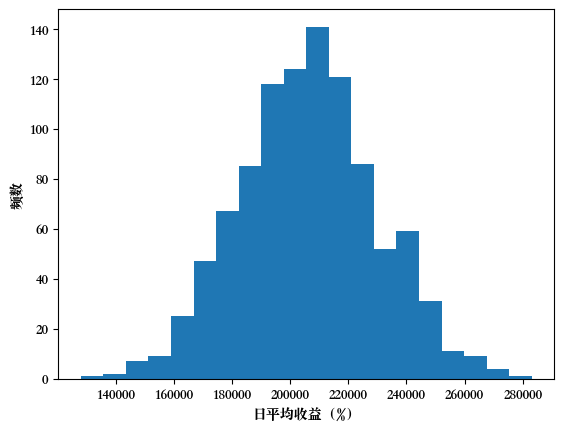

In [95]:
f=plt.figure()
plt.hist(result[:,1],bins=20)
plt.xlabel("日平均收益（%）")
plt.ylabel("频数")

拟合的均值: 127761603.5391
拟合的标准差: 17176487.3881


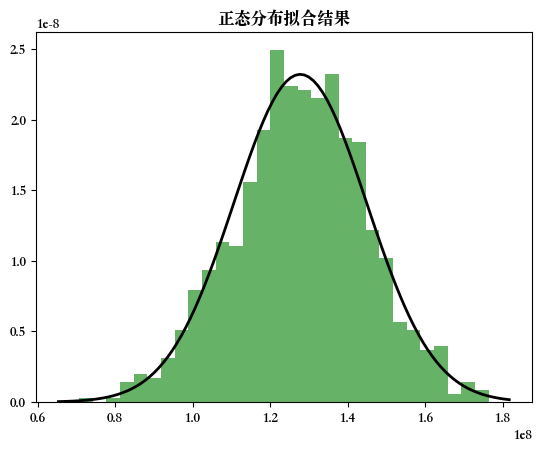

In [16]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 生成模拟数据
data = result2[:,0]

# 拟合正态分布
mu, std = norm.fit(data)

# 打印拟合参数
print(f"拟合的均值: {mu:.4f}")
print(f"拟合的标准差: {std:.4f}")

# 绘制直方图和拟合曲线
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# 绘制拟合的PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("正态分布拟合结果")
plt.show()

95% 左尾VaR (分界点): 99,190,106.06 元
95% 左尾CVaR (平均最差NPV): 126,513,549.53 元
与均值的差距: 1,930,845.17 元


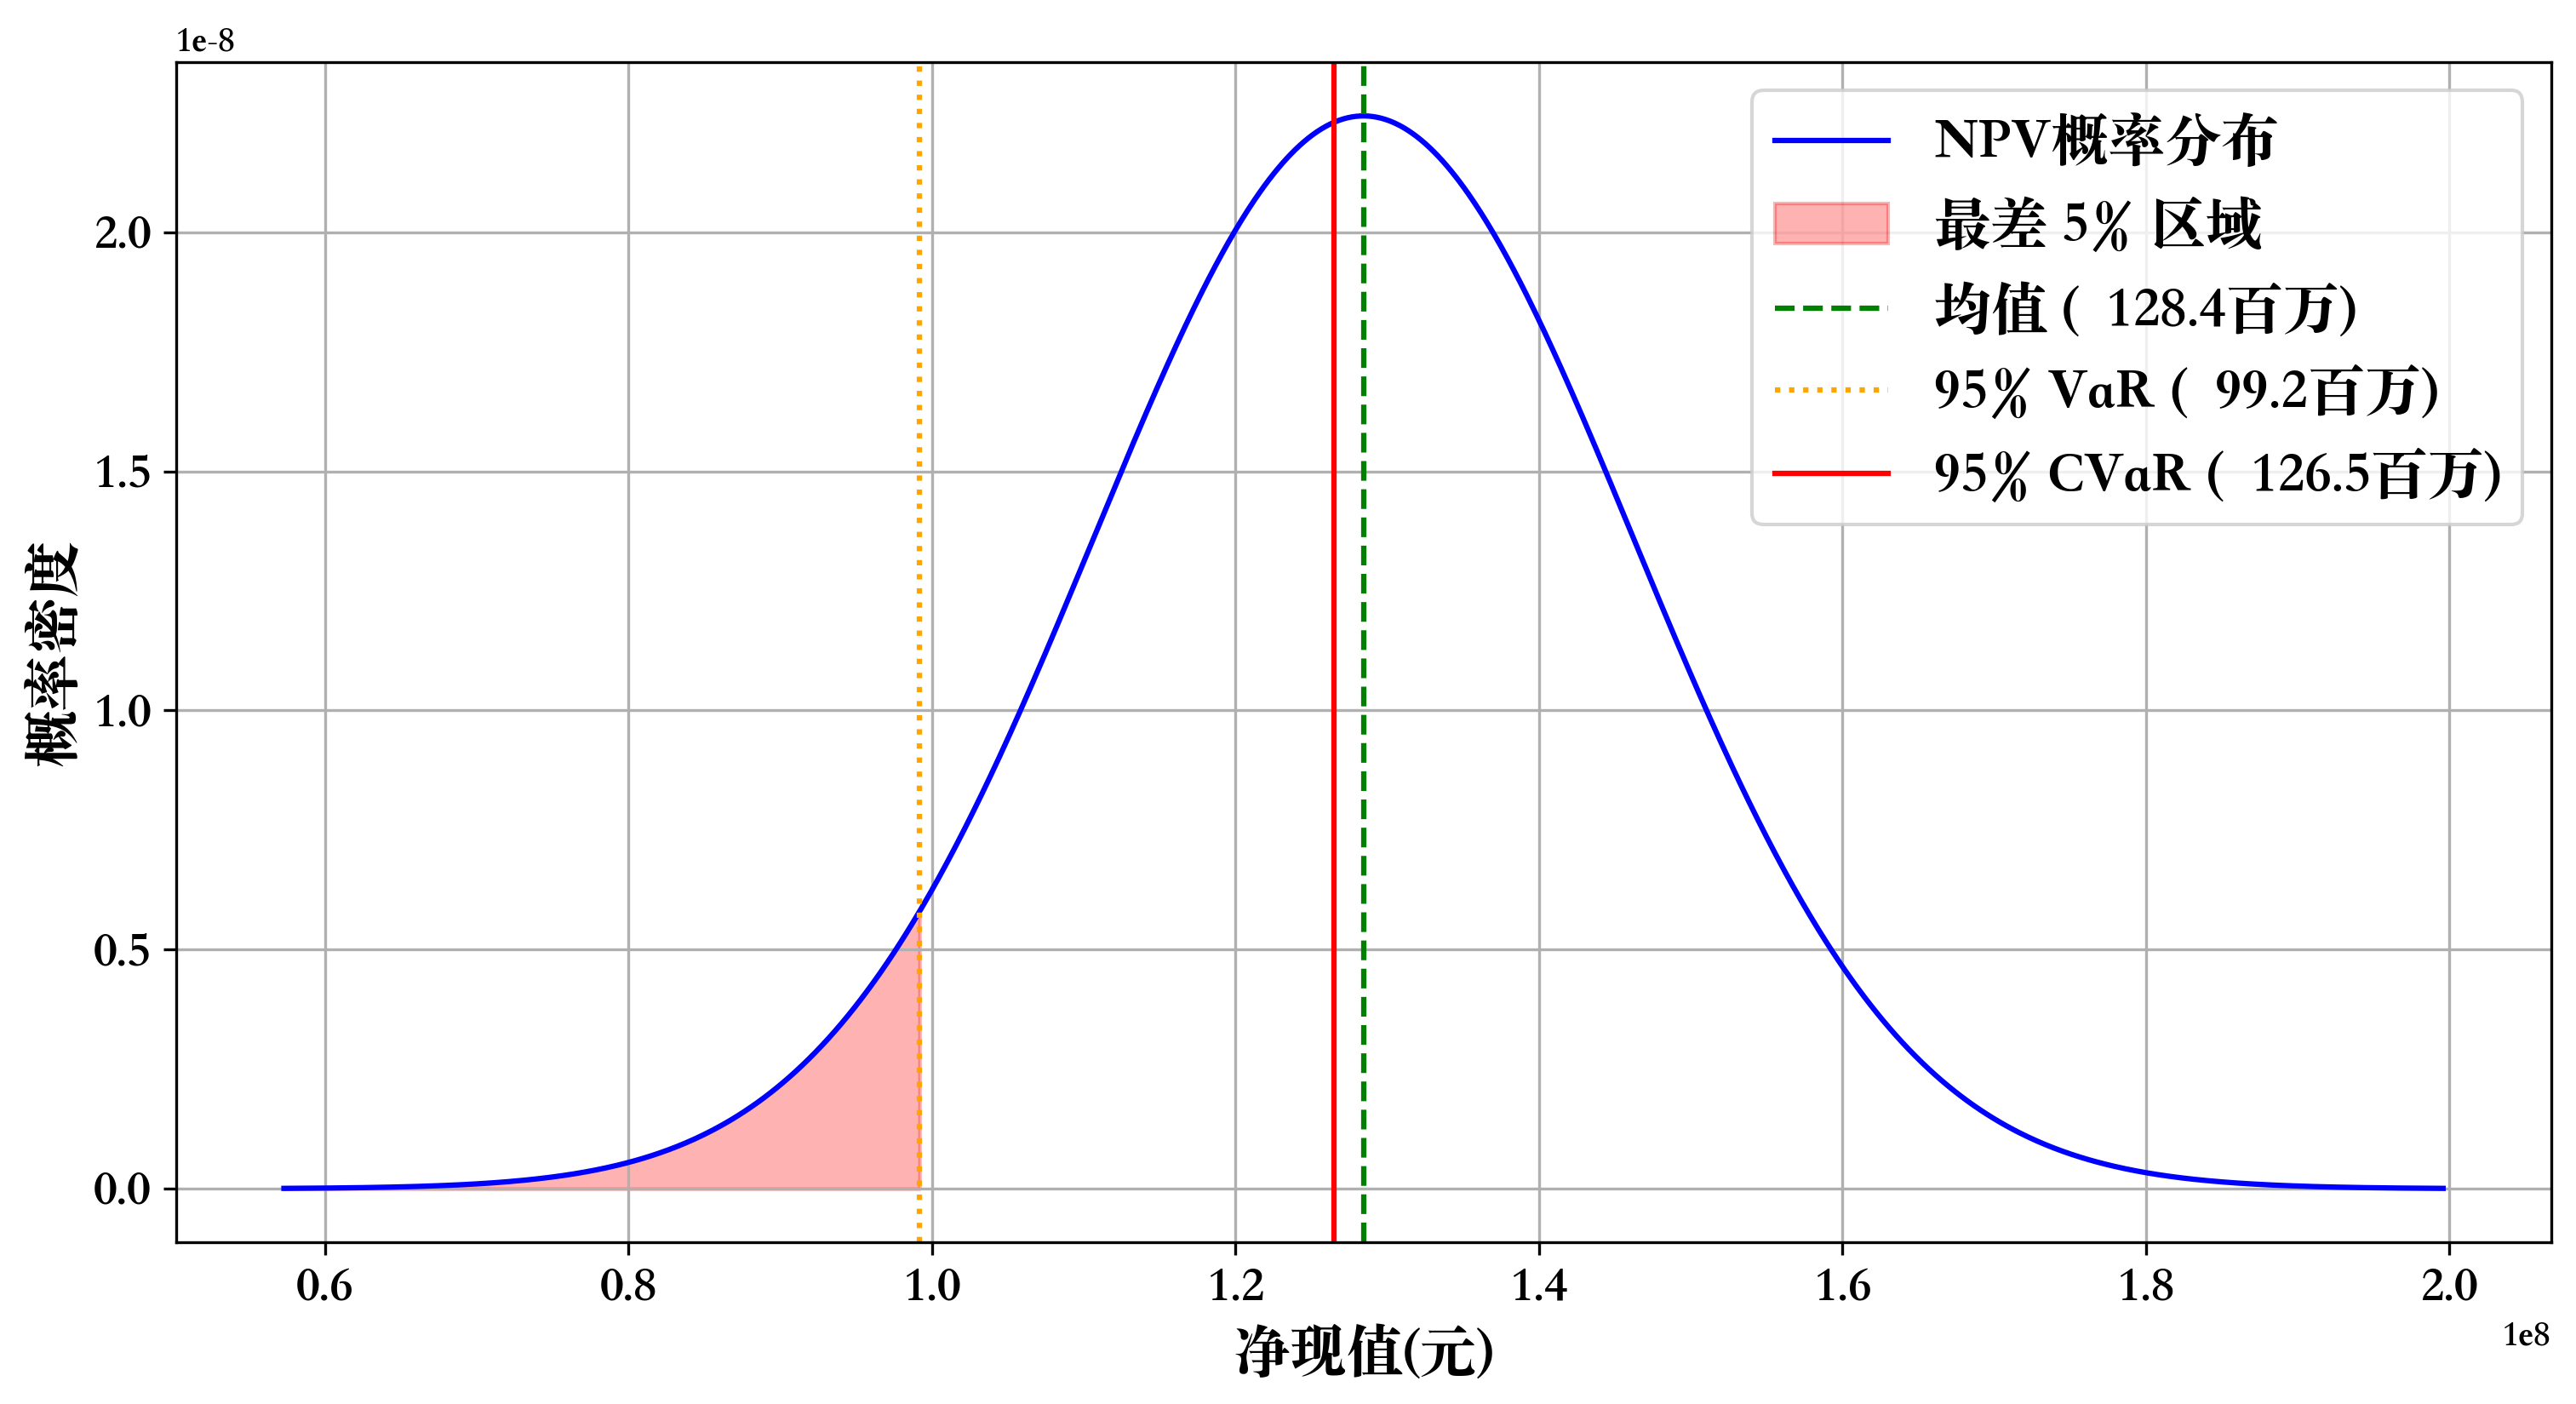

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Songti SC']  # Linux 常用
plt.rcParams['axes.unicode_minus'] = False 
# 输入参数（您的实际数据）
mu = 128444394.6988    # 均值
sigma = 17785344.6397  # 标准差
confidence_level = 0.95 # 置信水平

# ================= 正确计算左尾CVaR =================
def calculate_left_tail_cvar(mean, std, alpha):
    """计算左尾CVaR（针对NPV等希望值越大越好的指标）"""
    # 计算左尾VaR（alpha分位数）
    var = norm.ppf(1 - alpha, loc=mean, scale=std)
    
    # 计算左尾CVaR（NPV < VaR 时的平均值）
    # 通过正态分布性质直接计算（比模拟法更精确）
    z_alpha = norm.ppf(1 - alpha)
    cvar = mean - std * (norm.pdf(z_alpha) / alpha)
    return var, cvar

# 计算
var_95, cvar_95 = calculate_left_tail_cvar(mu, sigma, confidence_level)

# ================= 结果输出 =================
print(f"95% 左尾VaR (分界点): {var_95:,.2f} 元")
print(f"95% 左尾CVaR (平均最差NPV): {cvar_95:,.2f} 元")
print(f"与均值的差距: {mu - cvar_95:,.2f} 元")

# ================= 可视化 =================
plt.figure(figsize=(12, 6),dpi=300)

# 生成正态分布曲线
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = norm.pdf(x, mu, sigma)
plt.plot(x, y, 'b-', label='NPV概率分布')

# 标记左尾区域
x_left = np.linspace(mu - 4*sigma, var_95, 100)
y_left = norm.pdf(x_left, mu, sigma)
plt.fill_between(x_left, y_left, color='red', alpha=0.3, 
                label=f'最差 {100*(1-confidence_level):.0f}% 区域')

# 添加关键指标线
plt.axvline(mu, color='green', linestyle='--', label=f'均值 (¥{mu/1e6:.1f}百万)')
plt.axvline(var_95, color='orange', linestyle=':', label=f'95% VaR (¥{var_95/1e6:.1f}百万)')
plt.axvline(cvar_95, color='red', linestyle='-', label=f'95% CVaR (¥{cvar_95/1e6:.1f}百万)')

#plt.title("NPV分布左尾风险分析")
plt.xlabel("净现值(元)",fontsize=16)
plt.ylabel("概率密度",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.show()

In [69]:
# 计算多个置信水平
alphas = [0.90, 0.95, 0.99]
print("| 置信水平 | VaR阈值     | CVaR        | 与均值差距  |")
print("|----------|-------------|-------------|------------|")
for alpha in alphas:
    var, cvar = calculate_left_tail_cvar(mu, sigma, alpha)
    print(f"| {alpha*100:.0f}%     | ¥{var/1e6:.1f}百万 | ¥{cvar/1e6:.1f}百万 | ¥{mu-cvar/1e6:.1f}百万 |")

| 置信水平 | VaR阈值     | CVaR        | 与均值差距  |
|----------|-------------|-------------|------------|
| 90%     | ¥105.7百万 | ¥125.0百万 | ¥128444269.7百万 |
| 95%     | ¥99.2百万 | ¥126.5百万 | ¥128444268.2百万 |
| 99%     | ¥87.1百万 | ¥128.0百万 | ¥128444266.7百万 |


In [75]:
from scipy import stats
import numpy as np

# 示例数据
data = result[:,1]
hypothesized_mean = 207588.21946032904  # 您想要检验的理论值

# 执行单样本t检验
t_statistic, p_value = stats.ttest_1samp(data, popmean=hypothesized_mean)

# 输出结果
print(f"t统计量: {t_statistic:.4f}")
print(f"p值: {p_value:.4f}")

# 结果解释
alpha = 0.10  # 显著性水平
if p_value < alpha:
    print(f"拒绝原假设(p={p_value:.4f} < {alpha})，数据均值不等于{hypothesized_mean}")
else:
    print(f"不能拒绝原假设(p={p_value:.4f} ≥ {alpha})，没有足够证据表明均值不等于{hypothesized_mean}")

t统计量: -1.7174
p值: 0.0862
拒绝原假设(p=0.0862 < 0.1)，数据均值不等于207588.21946032904


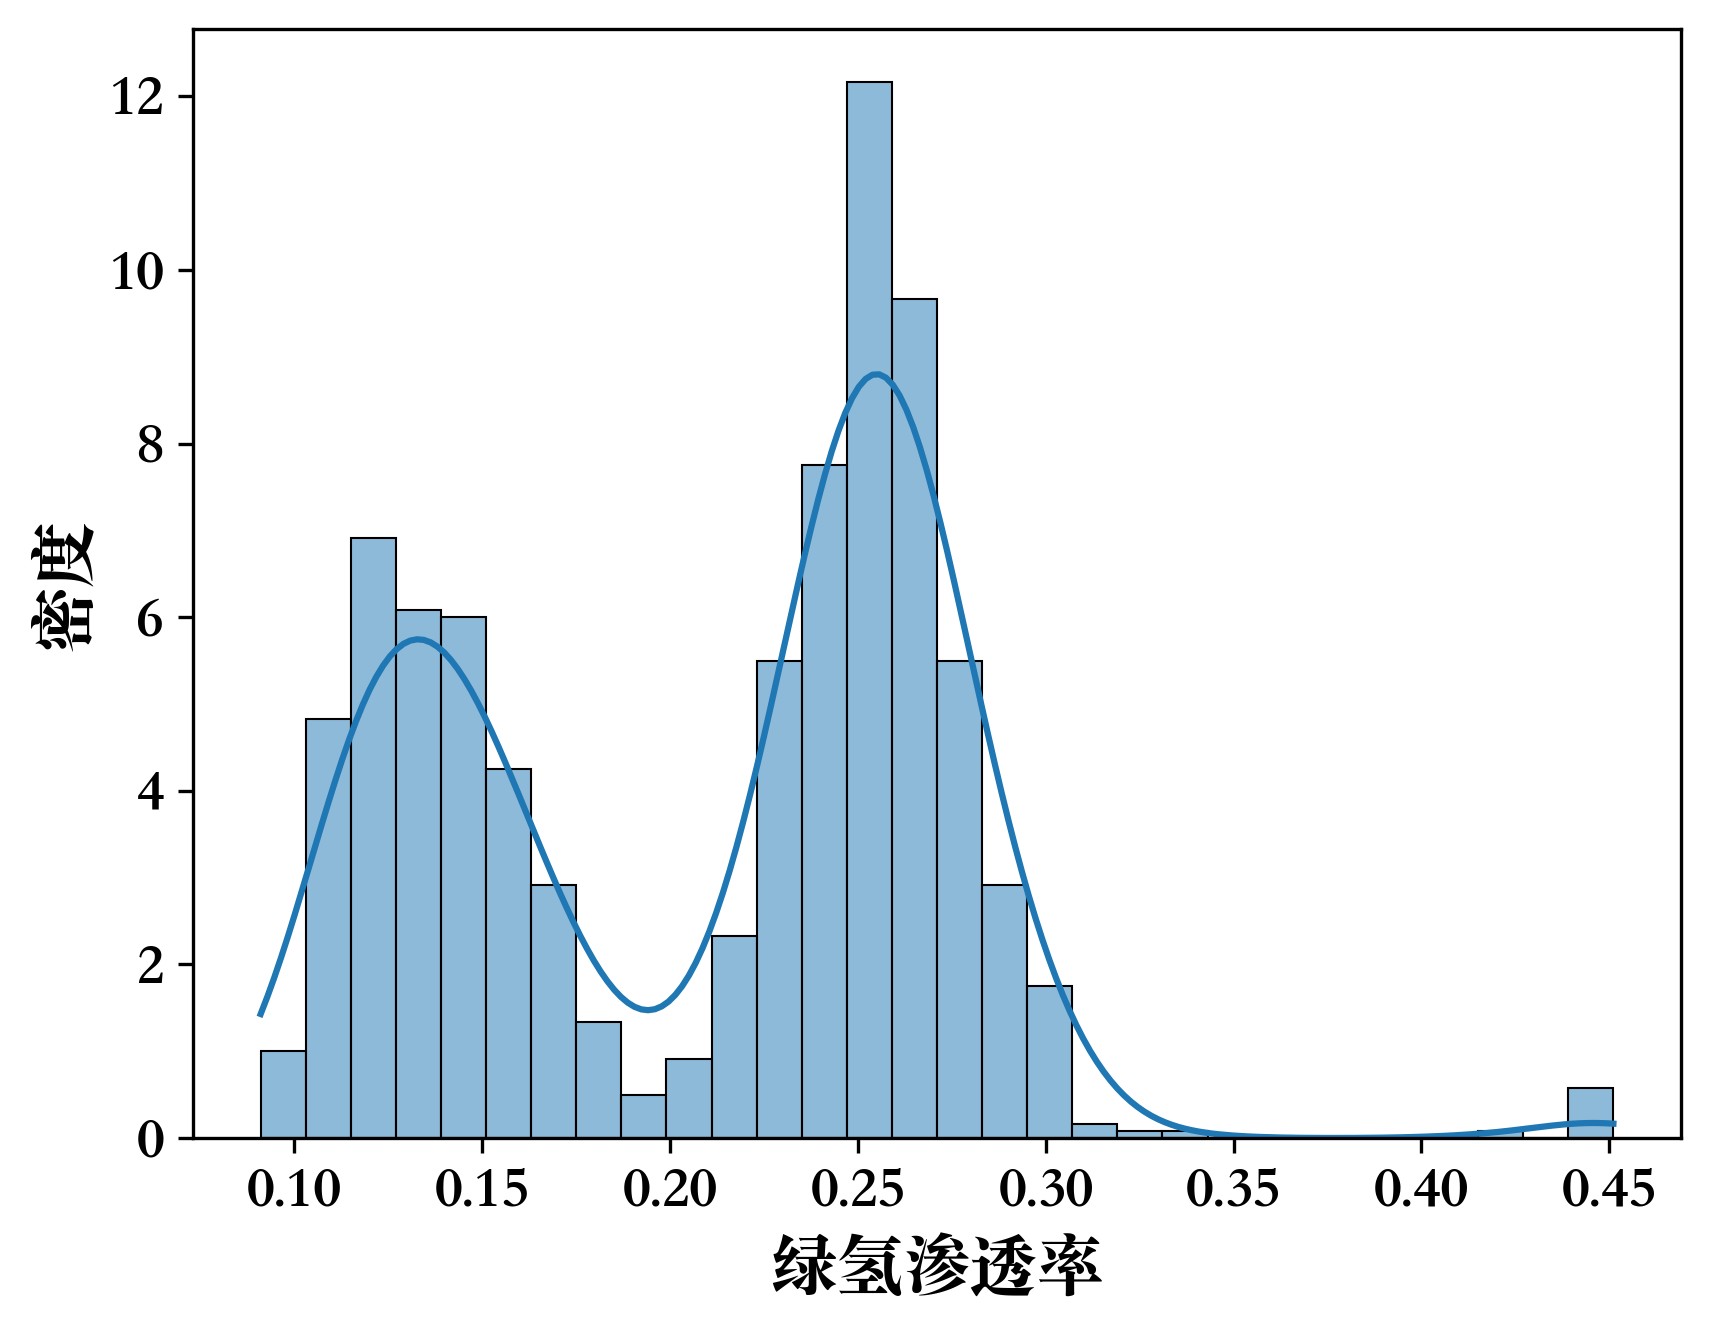

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据
data = result[:,0]
plt.rcParams['font.sans-serif'] = ['Songti SC']  # Linux 常用
plt.rcParams['axes.unicode_minus'] = False 
# 绘制带KDE的直方图
plt.figure(dpi=300)
sns.histplot(data, bins=30, kde=True, stat='density', 
            edgecolor='black', linewidth=0.5)

#plt.title('直方图+密度曲线（Seaborn）')
#plt.xlabel('绿氢渗透率')
plt.xlabel('绿氢渗透率',fontsize=16)
plt.ylabel('密度',fontsize=16)
plt.tick_params(labelsize=14)
plt.show()